In [3]:
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torch import nn
from PIL import Image
import os
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

In [4]:
%matplotlib inline

In [5]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=4, stride=2, padding=1),  # -> [32, 32, 32]
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),  # -> [128, 8, 8]
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),  # -> [256, 4, 4]
            nn.ReLU()
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),  # -> [128, 8, 8]
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # -> [64, 16, 16]
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # -> [32, 32, 32]
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, kernel_size=4, stride=2, padding=1),  # -> [1, 64, 64]
            nn.Sigmoid()  # Sigmoid to ensure the output is between 0 and 1
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [6]:
class CustomImageDataset(Dataset):
    def __init__(self, image_directory, transform=None):
        self.image_directory = image_directory
        self.image_filenames = [f for f in os.listdir(image_directory) if f.endswith(('.png', '.jpg', '.jpeg'))]
        self.transform = transform

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_directory, self.image_filenames[idx])
        image = Image.open(img_path).convert('L')  # Convert to grayscale

        if self.transform:
            image = self.transform(image)

        return image

In [7]:
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])  # For grayscale
])

In [8]:
train_dataset_path = "SmallerDataset/Train/"

In [9]:
train_dataset = CustomImageDataset(train_dataset_path, transform=transform)

In [10]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=False)

In [11]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [15]:
device

'cuda'

In [16]:
import torch.nn.init as init

def initialize_weights(model):
    for m in model.modules():
        if isinstance(m, (nn.Conv2d, nn.Linear)):
            init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            init.constant_(m.weight, 1)
            init.constant_(m.bias, 0)

In [17]:
# defining the model
model = Autoencoder().to(device)
initialize_weights(model)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [18]:
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    for batch_images in train_dataloader:
        batch_images = batch_images.to(device)

        # Forward pass
        outputs = model(batch_images)
        loss = criterion(outputs, batch_images)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')

  1%|          | 1/100 [00:22<37:42, 22.86s/it]

Epoch [1/100], Loss: 0.4864


  2%|▏         | 2/100 [00:45<36:53, 22.58s/it]

Epoch [2/100], Loss: 0.4864


  3%|▎         | 3/100 [01:07<35:58, 22.25s/it]

Epoch [3/100], Loss: 0.4658


  4%|▍         | 4/100 [01:28<34:54, 21.82s/it]

Epoch [4/100], Loss: 0.4619


  5%|▌         | 5/100 [01:49<34:05, 21.54s/it]

Epoch [5/100], Loss: 0.4592


  6%|▌         | 6/100 [02:11<34:07, 21.78s/it]

Epoch [6/100], Loss: 0.4567


  7%|▋         | 7/100 [02:33<34:01, 21.95s/it]

Epoch [7/100], Loss: 0.4545


  8%|▊         | 8/100 [02:55<33:30, 21.85s/it]

Epoch [8/100], Loss: 0.4527


  9%|▉         | 9/100 [03:17<33:05, 21.82s/it]

Epoch [9/100], Loss: 0.4518


 10%|█         | 10/100 [03:38<32:23, 21.59s/it]

Epoch [10/100], Loss: 0.4506


 11%|█         | 11/100 [04:00<32:07, 21.66s/it]

Epoch [11/100], Loss: 0.4498


 12%|█▏        | 12/100 [04:22<32:01, 21.83s/it]

Epoch [12/100], Loss: 0.4491


 13%|█▎        | 13/100 [04:44<31:46, 21.91s/it]

Epoch [13/100], Loss: 0.4487


 14%|█▍        | 14/100 [05:06<31:33, 22.02s/it]

Epoch [14/100], Loss: 0.4482


 15%|█▌        | 15/100 [05:27<30:47, 21.73s/it]

Epoch [15/100], Loss: 0.4478


 16%|█▌        | 16/100 [05:48<30:01, 21.45s/it]

Epoch [16/100], Loss: 0.4476


 17%|█▋        | 17/100 [06:10<30:03, 21.73s/it]

Epoch [17/100], Loss: 0.4473


 18%|█▊        | 18/100 [06:32<29:44, 21.77s/it]

Epoch [18/100], Loss: 0.4471


 19%|█▉        | 19/100 [06:54<29:26, 21.81s/it]

Epoch [19/100], Loss: 0.4470


 20%|██        | 20/100 [07:16<29:09, 21.87s/it]

Epoch [20/100], Loss: 0.4467


 21%|██        | 21/100 [07:37<28:15, 21.46s/it]

Epoch [21/100], Loss: 0.4467


 22%|██▏       | 22/100 [07:58<27:38, 21.26s/it]

Epoch [22/100], Loss: 0.4467


 23%|██▎       | 23/100 [08:19<27:18, 21.28s/it]

Epoch [23/100], Loss: 0.4465


 24%|██▍       | 24/100 [08:40<26:51, 21.20s/it]

Epoch [24/100], Loss: 0.4467


 25%|██▌       | 25/100 [09:01<26:22, 21.10s/it]

Epoch [25/100], Loss: 0.4463


 26%|██▌       | 26/100 [09:22<26:08, 21.20s/it]

Epoch [26/100], Loss: 0.4463


 27%|██▋       | 27/100 [11:26<1:03:08, 51.89s/it]

Epoch [27/100], Loss: 0.4460


 28%|██▊       | 28/100 [12:17<1:01:56, 51.62s/it]

Epoch [28/100], Loss: 0.4459


 29%|██▉       | 29/100 [12:37<50:03, 42.30s/it]  

Epoch [29/100], Loss: 0.4457


 30%|███       | 30/100 [12:58<41:41, 35.74s/it]

Epoch [30/100], Loss: 0.4456


 31%|███       | 31/100 [13:18<35:52, 31.20s/it]

Epoch [31/100], Loss: 0.4456


 32%|███▏      | 32/100 [13:39<31:38, 27.92s/it]

Epoch [32/100], Loss: 0.4455


 33%|███▎      | 33/100 [14:00<28:56, 25.91s/it]

Epoch [33/100], Loss: 0.4454


 34%|███▍      | 34/100 [14:21<27:06, 24.64s/it]

Epoch [34/100], Loss: 0.4454


 35%|███▌      | 35/100 [14:43<25:48, 23.82s/it]

Epoch [35/100], Loss: 0.4452


 36%|███▌      | 36/100 [15:05<24:49, 23.28s/it]

Epoch [36/100], Loss: 0.4450


 37%|███▋      | 37/100 [15:28<24:06, 22.96s/it]

Epoch [37/100], Loss: 0.4450


 38%|███▊      | 38/100 [15:49<23:17, 22.54s/it]

Epoch [38/100], Loss: 0.4449


 39%|███▉      | 39/100 [16:12<22:58, 22.59s/it]

Epoch [39/100], Loss: 0.4448


 40%|████      | 40/100 [16:34<22:24, 22.41s/it]

Epoch [40/100], Loss: 0.4447


 41%|████      | 41/100 [16:56<22:00, 22.39s/it]

Epoch [41/100], Loss: 0.4446


 42%|████▏     | 42/100 [17:18<21:35, 22.33s/it]

Epoch [42/100], Loss: 0.4445


 43%|████▎     | 43/100 [17:39<20:44, 21.84s/it]

Epoch [43/100], Loss: 0.4446


 44%|████▍     | 44/100 [18:01<20:22, 21.83s/it]

Epoch [44/100], Loss: 0.4446


 45%|████▌     | 45/100 [18:23<20:03, 21.88s/it]

Epoch [45/100], Loss: 0.4447


 46%|████▌     | 46/100 [18:45<19:49, 22.03s/it]

Epoch [46/100], Loss: 0.4446


 47%|████▋     | 47/100 [19:08<19:34, 22.16s/it]

Epoch [47/100], Loss: 0.4446


 48%|████▊     | 48/100 [19:29<18:58, 21.90s/it]

Epoch [48/100], Loss: 0.4445


 49%|████▉     | 49/100 [19:50<18:29, 21.76s/it]

Epoch [49/100], Loss: 0.4444


 50%|█████     | 50/100 [20:13<18:24, 22.09s/it]

Epoch [50/100], Loss: 0.4444


 51%|█████     | 51/100 [20:35<18:02, 22.09s/it]

Epoch [51/100], Loss: 0.4443


 52%|█████▏    | 52/100 [20:57<17:37, 22.03s/it]

Epoch [52/100], Loss: 0.4443


 53%|█████▎    | 53/100 [21:19<17:17, 22.07s/it]

Epoch [53/100], Loss: 0.4442


 54%|█████▍    | 54/100 [21:43<17:10, 22.40s/it]

Epoch [54/100], Loss: 0.4442


 55%|█████▌    | 55/100 [22:06<17:04, 22.77s/it]

Epoch [55/100], Loss: 0.4442


 56%|█████▌    | 56/100 [22:29<16:47, 22.90s/it]

Epoch [56/100], Loss: 0.4441


 57%|█████▋    | 57/100 [22:53<16:36, 23.18s/it]

Epoch [57/100], Loss: 0.4440


 58%|█████▊    | 58/100 [23:16<16:14, 23.20s/it]

Epoch [58/100], Loss: 0.4441


 59%|█████▉    | 59/100 [23:39<15:42, 22.98s/it]

Epoch [59/100], Loss: 0.4440


 60%|██████    | 60/100 [24:02<15:15, 22.90s/it]

Epoch [60/100], Loss: 0.4441


 61%|██████    | 61/100 [24:25<14:53, 22.91s/it]

Epoch [61/100], Loss: 0.4440


 62%|██████▏   | 62/100 [24:47<14:24, 22.75s/it]

Epoch [62/100], Loss: 0.4440


 63%|██████▎   | 63/100 [25:10<14:00, 22.71s/it]

Epoch [63/100], Loss: 0.4440


 64%|██████▍   | 64/100 [25:32<13:39, 22.77s/it]

Epoch [64/100], Loss: 0.4440


 65%|██████▌   | 65/100 [25:55<13:17, 22.77s/it]

Epoch [65/100], Loss: 0.4440


 66%|██████▌   | 66/100 [26:18<12:55, 22.80s/it]

Epoch [66/100], Loss: 0.4439


 67%|██████▋   | 67/100 [26:41<12:32, 22.80s/it]

Epoch [67/100], Loss: 0.4440


 68%|██████▊   | 68/100 [27:04<12:11, 22.85s/it]

Epoch [68/100], Loss: 0.4439


 69%|██████▉   | 69/100 [27:27<11:46, 22.78s/it]

Epoch [69/100], Loss: 0.4439


 70%|███████   | 70/100 [27:50<11:26, 22.87s/it]

Epoch [70/100], Loss: 0.4438


 71%|███████   | 71/100 [28:13<11:09, 23.07s/it]

Epoch [71/100], Loss: 0.4439


 72%|███████▏  | 72/100 [28:37<10:49, 23.18s/it]

Epoch [72/100], Loss: 0.4438


 73%|███████▎  | 73/100 [29:00<10:28, 23.29s/it]

Epoch [73/100], Loss: 0.4438


 74%|███████▍  | 74/100 [29:23<10:05, 23.30s/it]

Epoch [74/100], Loss: 0.4438


 75%|███████▌  | 75/100 [29:46<09:37, 23.09s/it]

Epoch [75/100], Loss: 0.4438


 76%|███████▌  | 76/100 [30:09<09:14, 23.10s/it]

Epoch [76/100], Loss: 0.4439


 77%|███████▋  | 77/100 [30:32<08:49, 23.00s/it]

Epoch [77/100], Loss: 0.4438


 78%|███████▊  | 78/100 [30:55<08:26, 23.01s/it]

Epoch [78/100], Loss: 0.4438


 79%|███████▉  | 79/100 [31:18<08:01, 22.95s/it]

Epoch [79/100], Loss: 0.4438


 80%|████████  | 80/100 [31:39<07:29, 22.46s/it]

Epoch [80/100], Loss: 0.4438


 81%|████████  | 81/100 [32:01<07:05, 22.37s/it]

Epoch [81/100], Loss: 0.4438


 82%|████████▏ | 82/100 [32:23<06:40, 22.27s/it]

Epoch [82/100], Loss: 0.4438


 83%|████████▎ | 83/100 [32:45<06:16, 22.16s/it]

Epoch [83/100], Loss: 0.4439


 84%|████████▍ | 84/100 [33:07<05:53, 22.12s/it]

Epoch [84/100], Loss: 0.4437


 85%|████████▌ | 85/100 [33:30<05:33, 22.24s/it]

Epoch [85/100], Loss: 0.4437


 86%|████████▌ | 86/100 [33:52<05:12, 22.29s/it]

Epoch [86/100], Loss: 0.4436


 87%|████████▋ | 87/100 [34:15<04:50, 22.35s/it]

Epoch [87/100], Loss: 0.4436


 88%|████████▊ | 88/100 [34:37<04:27, 22.31s/it]

Epoch [88/100], Loss: 0.4437


 89%|████████▉ | 89/100 [35:00<04:07, 22.51s/it]

Epoch [89/100], Loss: 0.4436


 90%|█████████ | 90/100 [35:23<03:47, 22.70s/it]

Epoch [90/100], Loss: 0.4436


 91%|█████████ | 91/100 [35:45<03:23, 22.60s/it]

Epoch [91/100], Loss: 0.4435


 92%|█████████▏| 92/100 [36:08<03:01, 22.74s/it]

Epoch [92/100], Loss: 0.4436


 93%|█████████▎| 93/100 [36:31<02:39, 22.80s/it]

Epoch [93/100], Loss: 0.4436


 94%|█████████▍| 94/100 [36:54<02:15, 22.63s/it]

Epoch [94/100], Loss: 0.4435


 95%|█████████▌| 95/100 [37:16<01:52, 22.44s/it]

Epoch [95/100], Loss: 0.4435


 96%|█████████▌| 96/100 [37:37<01:28, 22.13s/it]

Epoch [96/100], Loss: 0.4435


 97%|█████████▋| 97/100 [38:00<01:07, 22.36s/it]

Epoch [97/100], Loss: 0.4435


 98%|█████████▊| 98/100 [38:23<00:45, 22.67s/it]

Epoch [98/100], Loss: 0.4435


 99%|█████████▉| 99/100 [38:46<00:22, 22.82s/it]

Epoch [99/100], Loss: 0.4435


100%|██████████| 100/100 [39:09<00:00, 23.50s/it]

Epoch [100/100], Loss: 0.4435


In [19]:
# Save the model's state_dict
torch.save(model.state_dict(), 'autoencoder_model_gray.pth')

In [20]:
def visualize_reconstruction(model, image_path, transform, device='cuda'):
    """
    Visualizes the original and reconstructed image from the model.

    Args:
    - model (nn.Module): Trained autoencoder model.
    - image_path (str): Path to the input image.
    - transform (transforms.Compose): Transformations to apply to the image before inference.
    - device (str): Device to which model and data should be moved before inference. Default: 'cuda'.

    Returns:
    - reconstruction_error (float): Mean Squared Error between the original and reconstructed image.
    """
    model.eval()  # Set model to evaluation mode

    # Load the image and apply transformations
    image = Image.open(image_path).convert('L')  # Convert to grayscale
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    model = model.to(device)
    image_tensor = image_tensor.to(device)

    # Get the reconstructed image
    with torch.no_grad():
        reconstructed_tensor = model(image_tensor)

    # Compute the reconstruction error (MSE)
    mse_loss = torch.nn.functional.mse_loss(image_tensor, reconstructed_tensor)
    reconstruction_error = mse_loss.item()

    # Convert tensors to numpy arrays for visualization
    original_image = image_tensor.squeeze().cpu().numpy()
    reconstructed_image = reconstructed_tensor.squeeze().cpu().numpy()

    # Assuming images were normalized to [-1, 1], denormalize for visualization
    original_image = (original_image * 0.5) + 0.5
    reconstructed_image = (reconstructed_image * 0.5) + 0.5

    # Visualization using Matplotlib
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.imshow(original_image, cmap='gray')  # Use the 'gray' colormap for grayscale images
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap='gray')  # Use the 'gray' colormap for grayscale images
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

    return reconstruction_error


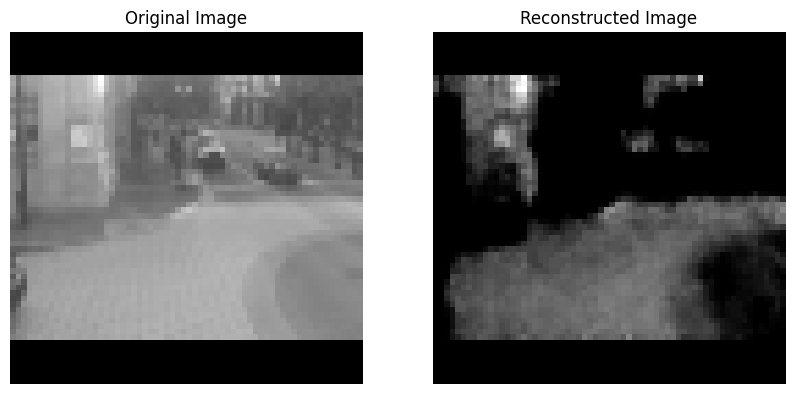

0.26580744981765747

In [21]:
# normal image
normal_image = "SmallerDataset/Test/Normal_Videos_912_x264_340.png"
visualize_reconstruction(model,  normal_image, transform, device=device)

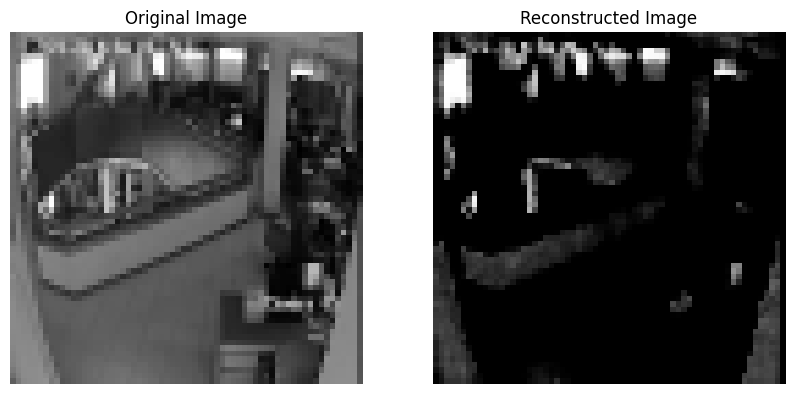

0.0986875593662262

In [22]:
normal_image_2 = "SmallerDataset/Test/Normal_Videos_923_x264_10660.png"
visualize_reconstruction(model,  normal_image_2, transform, device=device)

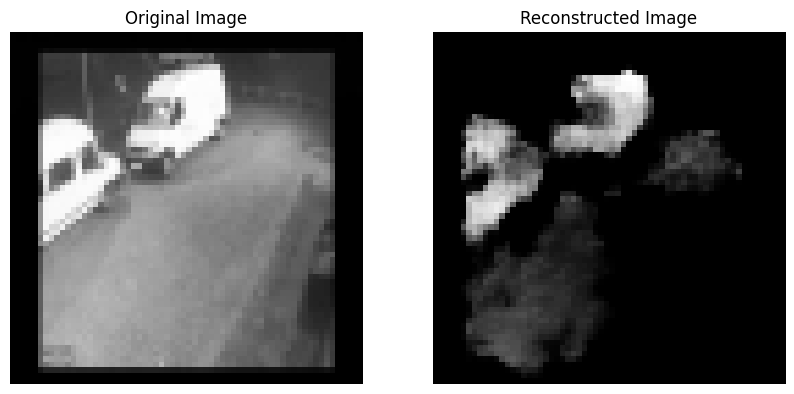

0.31232061982154846

In [23]:
# anomaly images
anomaly_1 = "SmallerDataset/AnomalyImages/Arson010_x264_1460.png"
visualize_reconstruction(model,  anomaly_1, transform, device=device)


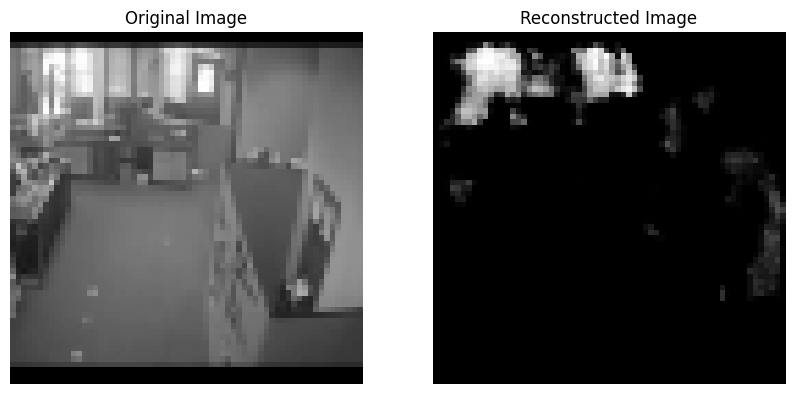

0.16118952631950378

In [24]:
anomaly_2 = "SmallerDataset/AnomalyImages/Arrest001_x264_480.png"
visualize_reconstruction(model,  anomaly_2, transform, device=device)

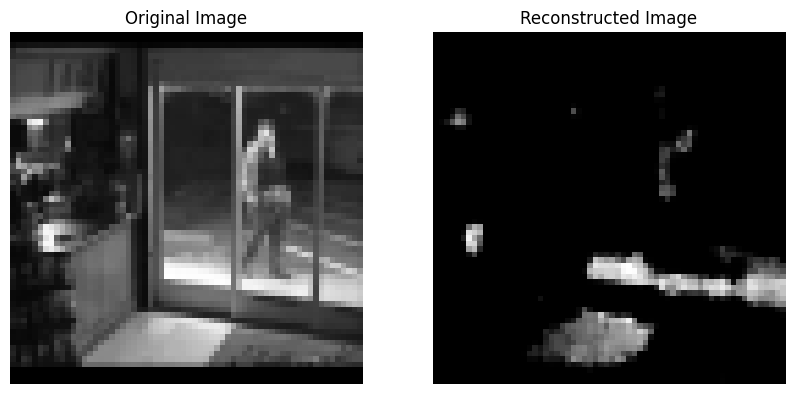

0.3710850179195404

In [25]:
anomaly_3 = "SmallerDataset/AnomalyImages/Vandalism017_x264_540.png"
visualize_reconstruction(model, anomaly_3, transform, device=device)

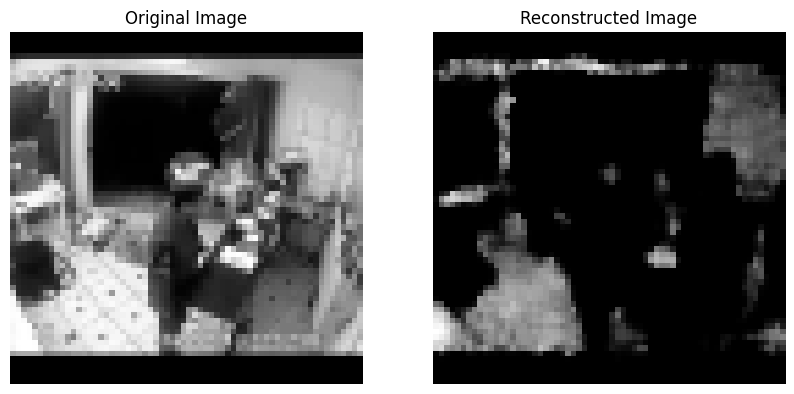

0.3669866919517517

In [26]:
anomaly_4 = "SmallerDataset/AnomalyImages/Shooting011_x264_3980.png"
visualize_reconstruction(model, anomaly_4, transform, device=device)